In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pickle
import random
import concurrent.futures

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dirtrain = '/content/drive/MyDrive/archive/Original Data/train'
dirtest = '/content/drive/MyDrive/archive/Original Data/test'

In [4]:
categories=["Black_rot","Esca_(Black_Measles)","Healthy","Leaf_blight_(Isariopsis_Leaf_Spot)"]

In [5]:
# Custom F1-Score Metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [6]:
def process_image(path, class_num):
    try:
        img_array = cv2.imread(path)
        img_array = cv2.resize(img_array, (256, 256))  # Resize to 256x256
        return [img_array, class_num]
    except Exception as e:
        return None

Healthy
Black_rot
.ipynb_checkpoints
Black_Measles
Leaf_blight


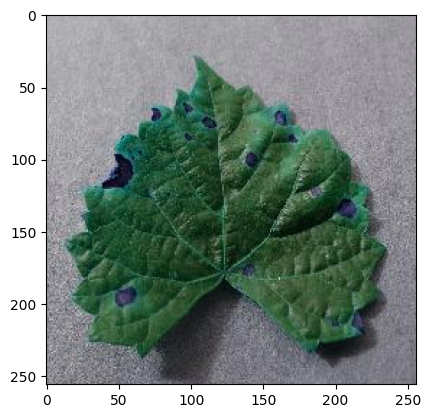

In [7]:
import os

# Specify the path where your files are located within your Google Drive
path = '/content/drive/MyDrive/archive/Original Data/train'

# List all files in the directory specified by path
files = os.listdir(path)

# Iterate over each file in the directory
for filename in files:
    # Do something with each file, for example, print its name
    print(filename)

for c in categories:
    path=os.path.join(dirtrain,c)
    for i in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,i))
        #print(img_array.shape)
        plt.imshow(img_array)
        plt.show()
        break
    break



In [10]:
training_data = []
def create_training_data():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for c in categories:
            path = os.path.join(dirtrain, c)
            class_num = categories.index(c)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                futures.append(executor.submit(process_image, img_path, class_num))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                training_data.append(result)
    return training_data
count_train = create_training_data()

In [11]:
testing_data = []
def create_testing_data():
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for c in categories:
            path = os.path.join(dirtest, c)
            class_num = categories.index(c)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                futures.append(executor.submit(process_image, img_path, class_num))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                testing_data.append(result)
    return testing_data

count_test = create_testing_data()

In [12]:
print(len(training_data))
print(count_train)
print(len(testing_data))
print(count_test)

Streaming output truncated to the last 5000 lines.

       [[152, 162, 172],
        [150, 160, 170],
        [149, 159, 169],
        ...,
        [143, 151, 168],
        [107, 115, 132],
        [119, 127, 144]]], dtype=uint8), 3], [array([[[187, 189, 190],
        [192, 194, 195],
        [207, 209, 210],
        ...,
        [140, 143, 147],
        [131, 134, 138],
        [148, 151, 155]],

       [[197, 199, 200],
        [191, 193, 194],
        [198, 200, 201],
        ...,
        [146, 149, 153],
        [141, 144, 148],
        [155, 158, 162]],

       [[199, 201, 202],
        [186, 188, 189],
        [189, 191, 192],
        ...,
        [154, 157, 161],
        [153, 156, 160],
        [159, 162, 166]],

       ...,

       [[153, 154, 164],
        [111, 112, 122],
        [167, 168, 178],
        ...,
        [121, 125, 136],
        [125, 129, 140],
        [119, 123, 134]],

       [[120, 121, 131],
        [137, 138, 148],
        [149, 150, 160],
        ...,
   

In [13]:
random.shuffle(count_train)
random.shuffle(count_test)

In [14]:
x_train = []
y_train = []
x_test = []
y_test = []

In [15]:
for features, label in count_train:
    x_train.append(features)
    y_train.append(label)
x_train = np.array(x_train).reshape(-1, 256, 256, 3)


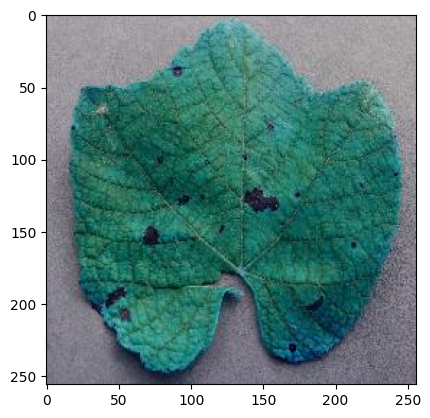

In [16]:
x=cv2.resize(training_data[0][0],(256,256))
plt.imshow(x,cmap='gray')

In [17]:
for features, label in count_test:
    x_test.append(features)
    y_test.append(label)
x_test = np.array(x_test).reshape(-1, 256, 256, 3)

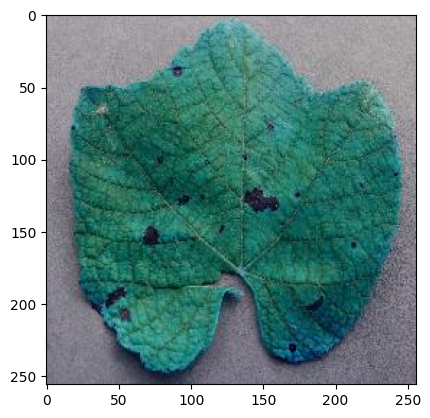

In [18]:
plt.imshow(x_train[0])
plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
'''train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)'''

"train_datagen = ImageDataGenerator(\n    rescale=1./255,\n    shear_range=0.2,\n    zoom_range=0.2,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    horizontal_flip=True,\n    vertical_flip=True,\n    fill_mode='nearest'\n)"

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
y_train_cat = to_categorical(y_train, num_classes=len(categories))
y_test_cat = to_categorical(y_test, num_classes=len(categories))

In [22]:
'''train_generator = train_datagen.flow_from_directory(
    dirtrain,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
     classes=["Black_rot","Esca_(Black_Measles)","Healthy","Leaf_blight_(Isariopsis_Leaf_Spot)"]
)'''
train_generator = train_datagen.flow_from_directory(
    dirtrain,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=["Black_rot","Esca_(Black_Measles)","Healthy","Leaf_blight_(Isariopsis_Leaf_Spot)"]
)

Found 7222 images belonging to 4 classes.


In [23]:
'''validation_generator = test_datagen.flow_from_directory(
    dirtest,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    classes = ["Black_rot","Esca_(Black_Measles)","Healthy","Leaf_blight_(Isariopsis_Leaf_Spot)"]
)'''
validation_generator = test_datagen.flow_from_directory(
    dirtest,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=["Black_rot","Esca_(Black_Measles)","Healthy","Leaf_blight_(Isariopsis_Leaf_Spot)"]
)

Found 1805 images belonging to 4 classes.


In [24]:
num_classes = len(train_generator.class_indices)
print(f'Number of classes: {num_classes}')

Number of classes: 4


In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
'''def create_model():
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = Dropout(0.5)(x)  # Add dropout for regularization
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                 tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(),
                 tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.AUC(curve='ROC'),
                 tf.keras.metrics.AUC(curve='PR'), F1Score()],)
  model.summary()
  return model'''

In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                 tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError(),
                 tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.AUC(curve='ROC'),
                 tf.keras.metrics.AUC(curve='PR'), F1Score()],)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
'''model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()'''

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
#best_model_path = 'best_model.keras'

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint


# Update the file path to use the .keras extension
best_model_path = 'best_model.keras'
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)



In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [29]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
'''model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])'''


In [ ]:
'''from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                        

In [ ]:
'''early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
'''

In [30]:
'''history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=50,  # Increase the number of epochs for better fine-tuning
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr]
)'''
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr,checkpoint]
    #callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8648 - auc: 0.9601 - auc_1: 0.9220 - f1_score: 0.8681 - loss: 5.3683 - mean_absolute_error: 0.0873 - mean_absolute_percentage_error: 43661296.0000 - precision: 0.8816 - recall: 0.8556 - root_mean_squared_error: 0.2148
Epoch 1: val_accuracy improved from -inf to 0.95759, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 659s 3s/step - accuracy: 0.8651 - auc: 0.9603 - auc_1: 0.9222 - f1_score: 0.8683 - loss: 5.3566 - mean_absolute_error: 0.0872 - mean_absolute_percentage_error: 43588052.0000 - precision: 0.8818 - recall: 0.8559 - root_mean_squared_error: 0.2146 - val_accuracy: 0.9576 - val_auc: 0.9975 - val_auc_1: 0.9927 - val_f1_score: 0.9572 - val_loss: 0.6194 - val_mean_absolute_error: 0.0361 - val_mean_absolute_percentage_error: 18056958.0000 - val_precision: 0.9591 - val_recall: 0.9554 - val_root_mean_squared_error: 0.1268 - learning_rate: 0.0010
Epoch 2/10
  1/225 ━━━━━━━━━━━━━━━━━━━━ 4:56 1s/step - accura

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.95759 to 0.96484, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 118s 519ms/step - accuracy: 0.9375 - auc: 0.9980 - auc_1: 0.9941 - f1_score: 0.9375 - loss: 0.6268 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 20677948.0000 - precision: 0.9375 - recall: 0.9375 - root_mean_squared_error: 0.1370 - val_accuracy: 0.9648 - val_auc: 0.9983 - val_auc_1: 0.9950 - val_f1_score: 0.9648 - val_loss: 0.6009 - val_mean_absolute_error: 0.0326 - val_mean_absolute_percentage_error: 16292896.0000 - val_precision: 0.9664 - val_recall: 0.9632 - val_root_mean_squared_error: 0.1166 - learning_rate: 0.0010
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9435 - auc: 0.9957 - auc_1: 0.9882 - f1_score: 0.9444 - loss: 0.5372 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 20724102.0000 - precision: 0.9481 - recall: 0.9408 - root_mean_squared_error: 0.1427
Epoch 3: val_accuracy improved from 0.96484 to 0.97154

In [31]:
import pandas as pd
# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

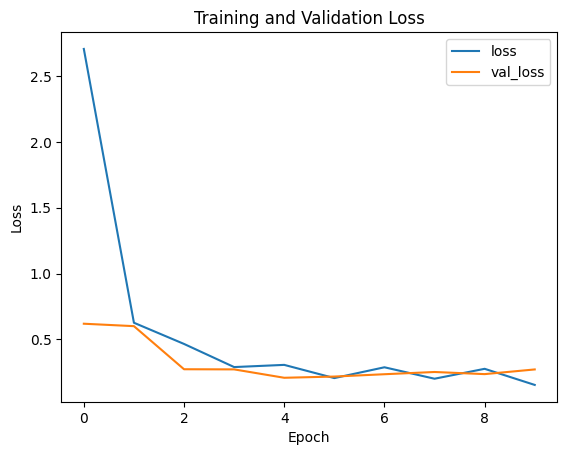

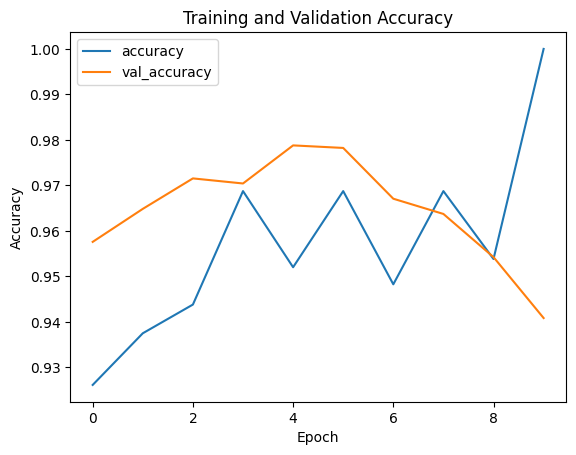

In [32]:
# Plot the training and validation loss
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [33]:
# Print the best validation metrics
print(f"Best Validation Loss: {history_df['val_loss'].min()}" +
      f"\nBest Validation Accuracy: {history_df['val_accuracy'].max()}" +
      f"\nBest Recall: {history_df['val_recall'].max()}" +
      f"\nBest Precision: {history_df['val_precision'].max()}" +
      f"\nBest F1-Score: {history_df['val_f1_score'].max()}"
)

Best Validation Loss: 0.2089477926492691
Best Validation Accuracy: 0.9787946343421936
Best Recall: 0.9782366156578064
Best Precision: 0.9793180823326111
Best F1-Score: 0.9785096049308777


In [34]:
# Evaluate the model
loss, accuracy, precision, recall, rmse, mape, mae, auc_roc, auc_pr, f1 = model.evaluate(validation_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9808 - auc: 0.9993 - auc_1: 0.9979 - f1_score: 0.9807 - loss: 0.2072 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 12977171.0000 - precision: 0.9808 - recall: 0.9805 - root_mean_squared_error: 0.0930


57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step


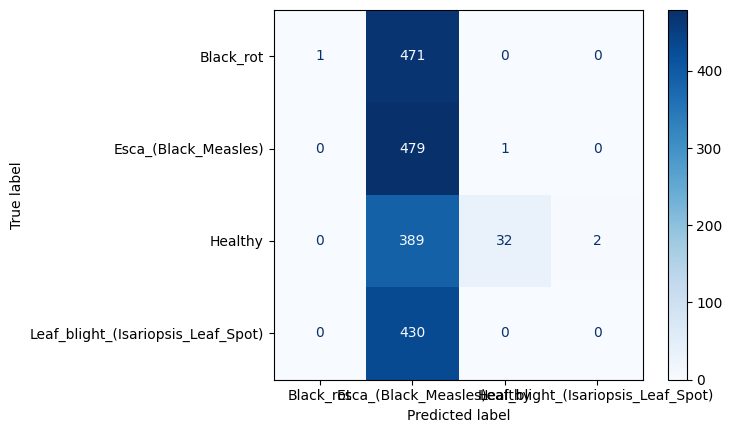

In [ ]:
'''from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import resize
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Resize the test images to match the input size of the model
def resize_images(images, target_size=(224, 224)):
    resized_images = np.array([resize(img, target_size) for img in images])
    return resized_images

# Resize the x_test array
x_test_resized = resize_images(x_test, target_size=(224, 224))

# Predict the labels for the resized test set
y_pred_prob = best_model.predict(x_test_resized)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()'''


57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step


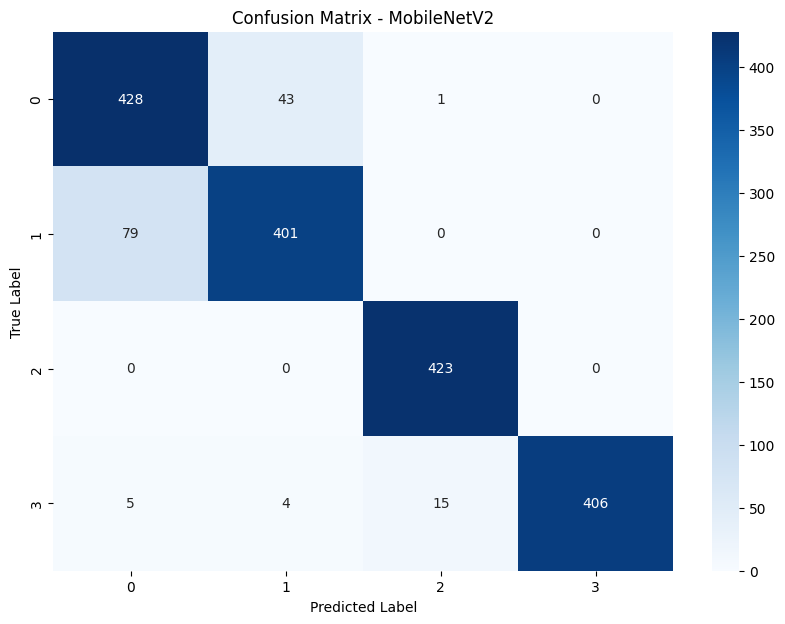

                                    precision    recall  f1-score   support

                         Black_rot       0.84      0.91      0.87       472
              Esca_(Black_Measles)       0.90      0.84      0.86       480
                           Healthy       0.96      1.00      0.98       423
Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      0.94      0.97       430

                          accuracy                           0.92      1805
                         macro avg       0.92      0.92      0.92      1805
                      weighted avg       0.92      0.92      0.92      1805



In [35]:
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def resize_images(images, size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Assuming you have X_test and y_test for the MobileNetV2 model
# Resize and normalize X_test
X_test_resized = resize_images(x_test)
X_test_resized = X_test_resized / 255.0

# Predict the classes for the test set
y_pred = model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=categories))

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [71]:
model.save("/content/drive/MyDrive/mymodel.keras")


In [70]:
import os

file_path = "/content/best_model.keras"

if os.path.exists(file_path):
    print("Model saved successfully!")
else:
    print("Model not found!")


Model saved successfully!


In [68]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/mymodel.keras")

TypeError: Could not locate class 'F1Score'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'F1Score', 'config': {'name': 'f1_score', 'dtype': 'float32'}, 'registered_name': 'F1Score'}

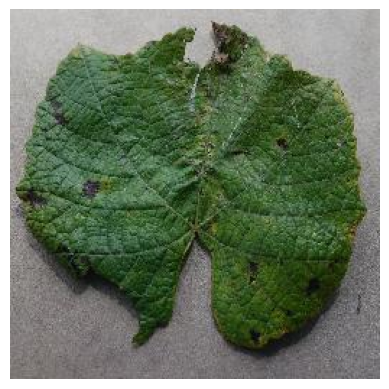

In [45]:
import cv2
import matplotlib.pyplot as plt

d = '/content/drive/MyDrive/archive/Original Data/test/Leaf_blight_(Isariopsis_Leaf_Spot)/043920d3-0542-4bd7-a8e5-3807c04a5bdc___FAM_L.Blight 1461.JPG'
img = cv2.imread(d)

# Check if img is None
if img is None:
    print("Error: Image not found or could not be loaded.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.axis('off')
    plt.show()


In [46]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model



# Load and preprocess a single image for prediction
img_path = '/content/drive/MyDrive/archive/Original Data/test/Leaf_blight_(Isariopsis_Leaf_Spot)/043920d3-0542-4bd7-a8e5-3807c04a5bdc___FAM_L.Blight 1461.JPG'  # Replace with your image path

# Load the image using OpenCV
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    raise ValueError("Image not found or unable to load the image from the specified path.")

# Check the shape of the loaded image
print(f"Original image shape: {img.shape}")

# Resize the image to the target size (224, 224)
img = cv2.resize(img, (224, 224))

# Check the shape of the resized image
print(f"Resized image shape: {img.shape}")

# Normalize the image
img = img / 255.0

# Reshape the image for the model
img = img.reshape(1, 224, 224, 3)  # Model expects shape (1, 224, 224, 3)

# Use the model to predict probabilities
predictions = model.predict(img)

# Find the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)


print("Predicted class:", predicted_class)


Original image shape: (256, 256, 3)
Resized image shape: (224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted class: [3]


In [47]:
categories[predicted_class[0]]

'Leaf_blight_(Isariopsis_Leaf_Spot)'